### We want to analyze the results of an experiment that were conducted with a team of data scientists. The experiment ran from 2022-09-03 to 2022-09-09 inclusive. For the experiment, groups 1 and 2 were involved. In group 2, one of the new post recommendation algorithms was used and it was used as a test group, group 1 was used as a control. The main hypothesis is that the new algorithm in the 2nd group will lead to an increase in CTR. To analyze the AB test data, I compared CTR in two groups and used several analysis methods such as t-test, Poisson bootstrap, Mann-Whitney test , t-test on smoothed ctr (alpha=5) as well as Mann-Whitney test over bucket transform. So after conducting these tests we should be able to answer the question whether to release this new post recommendation algorithm to the entire audience.

## 1. Let's plot CTR distributions in two groups and run tests.

### But first, let's get the data of the conducted experiment

In [1]:
import pandas as pd
import pandahouse as ph

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
select 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
where exp_group in (2,1)
and toDate(time) between toDate('2022-09-03') and toDate('2022-09-09')
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [3]:
df.groupby(['exp_group']).count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [5]:
import seaborn as sns

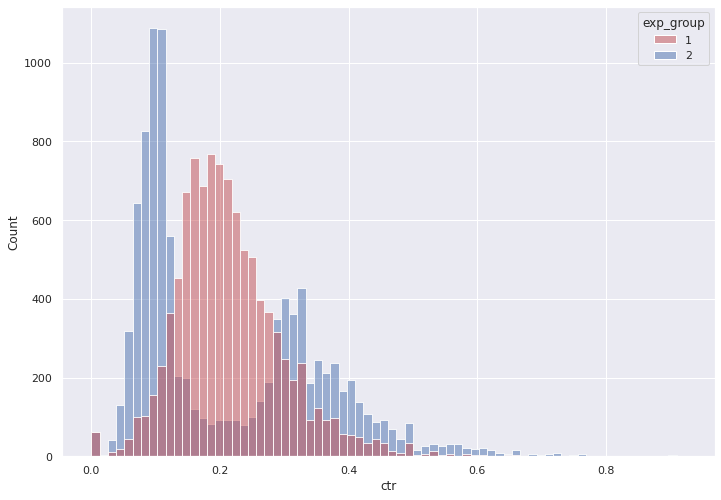

In [4]:
# CTR distribution
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

### Visually, the distributions of ctr in the groups are very different, which hints that the H1 hypothesis is supposedly correct. The distribution in group 1 is close to normal, the distribution in group 2 is shifted to the left and has 2 peaks.

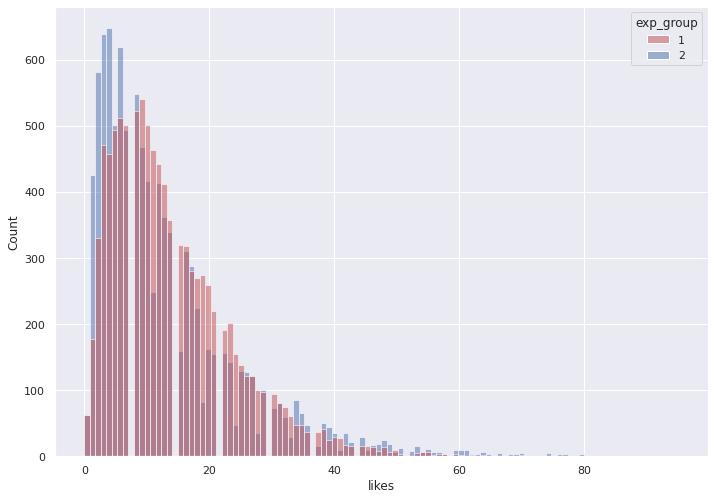

In [6]:
# Plot of likes distribution  
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
x='likes',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

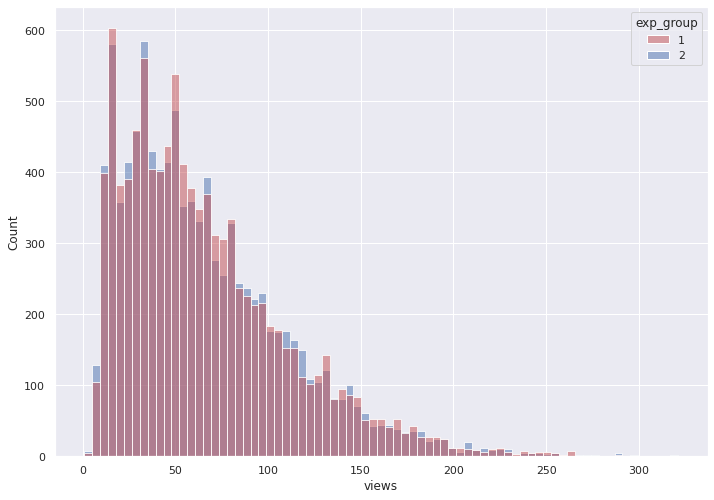

In [7]:
# Plot of views distribution  
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
x='views',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

In [35]:
from scipy import stats

In [36]:
# T-test
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

### However, the t-test result does not confirm this, because p-value>0.05 indicates that the null hypothesis cannot be rejected.

In [37]:
# Mann-Whitney
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
df[df.exp_group == 2].ctr,
alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### According to the results of Mann-Whitney, p-value<0.05, which indicates that the null hypothesis can be rejected.

In [38]:
import pandahouse

<AxesSubplot:xlabel='ctr', ylabel='Count'>

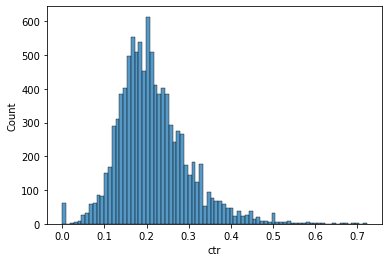

In [39]:
# smoothed CTR
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr
q = """
SELECT 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between toDate('2022-09-03') and toDate('2022-09-09')
and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

#CTR of the 1st group
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr,
kde = False)


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

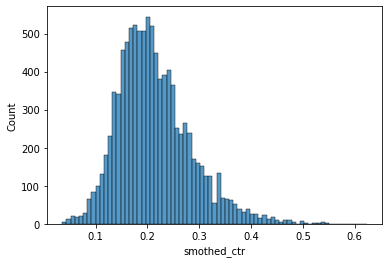

In [23]:
# smoothed CTR of the 1st group
group1['smoothed_ctr'] = df.apply(
lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
sns.histplot(group1.smoothed_ctr,
kde = False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

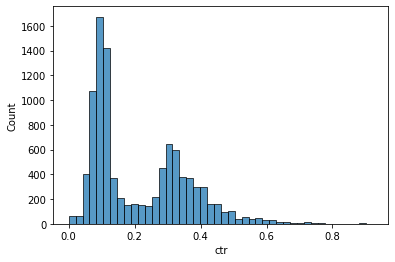

In [24]:
# CTR of the 2nd group
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr,
kde = False)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

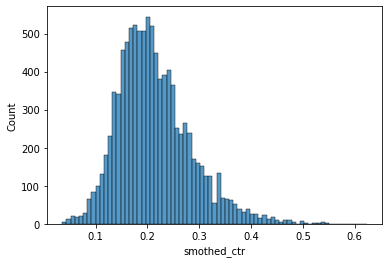

In [25]:
# smoothed CTR of the 2nd group
group2['smoothed_ctr'] = df.apply(
lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
sns.histplot(group1.smothed_ctr,
kde = False)

### It can be seen that the distribution of CTR in group 1 is close to normal, as are the distributions of smoothed ctr in groups 1 and 2 with one pronounced peak and relatively symmetrical tails.


In [26]:
#t-test on smoothed CTR (alpha=5)
stats.ttest_ind(group1.smoothed_ctr,
                group2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

### The result of t-test on the smoothed CTR: p-value< 0.05, which means that on the smoothed ctr using t-test we can reject the null hypothesis.
### On the unsmoothed CTR, the applied t-test showed that the null hypothesis cannot be rejected.

<AxesSubplot:ylabel='Count'>

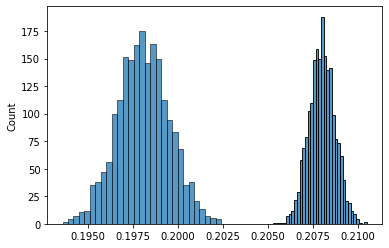

In [28]:
# Poisson bootstrap
import numpy as np
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

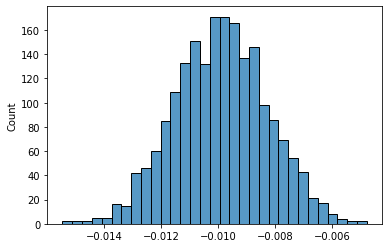

In [29]:
sns.histplot(ctr2 - ctr1)


### From the results of the Poisson bootstrap, it can be seen that the distribution of CTR2 is shifted to the left relative to CTR1 and repeats the distribution of CTR1 and CTR2 in the CTR distribution plot above. Looking at the result of shifting graphs CTR1 and CTR2 we can reject the null hypothesis.

In [30]:
(ctr2 - ctr1).mean()

-0.009912508402464956

In [32]:
(ctr2 - ctr1).std()

0.001627103684521931

### T-test over bucket transform

In [51]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9,
    medianDeterministic(ctr, 1) as mediana
FROM (SELECT exp_group, 
        xxHash64(user_id)%30 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.99076401123759, pvalue=4.839677350902954e-07)

### The result of applying the t-test on buckets showed that the null hypothesis can be rejected because p-value<0.05.

In [46]:
# Mann-Whitney test
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=790.0, pvalue=5.185675139382169e-07)

### The result of applying the Mann-Whitney test on buckets showed that the null hypothesis can be rejected because the p-value<0.05.

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

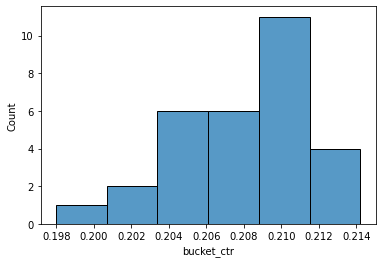

In [47]:
# bucket transform distribution of group 1
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

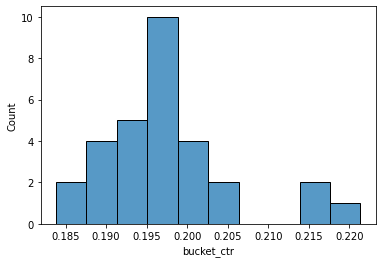

In [48]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

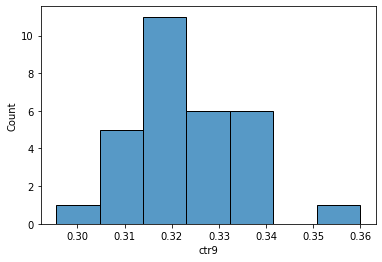

In [49]:
# 90% quntile distribution of group 1
sns.histplot(df[df.exp_group == 1].ctr9)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

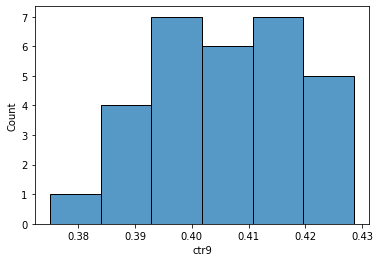

In [50]:
# 90% quntile distribution of group 2
sns.histplot(df[df.exp_group == 2].ctr9)

<AxesSubplot:xlabel='mediana', ylabel='Count'>

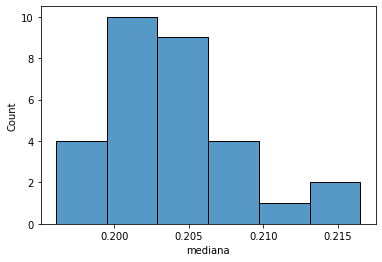

In [52]:
# median distribution of group 1
sns.histplot(df[df.exp_group == 1].mediana)

<AxesSubplot:xlabel='mediana', ylabel='Count'>

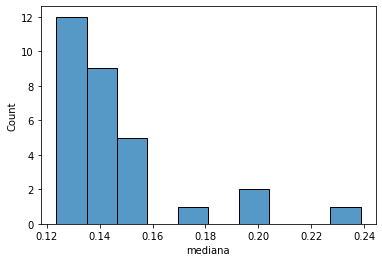

In [53]:
# median distribution of group 2
sns.histplot(df[df.exp_group == 2].mediana)

### The graphs show that the medians of the distribution of 30 buckets with CTR2 are shifted to the left relative to the medians for buckets with CTR1.

## 2. Conclusion

### Distribution:
### "normal" non-smoothed CTR: visually, the distributions of CTR in the groups are very different, which hints that the H1 hypothesis is supposedly correct. The distribution in group 1 is close to normal, the distribution in group 2 is shifted to the left and has 2 peaks.
### smoothed CTR: distributions of smoothed ctr in groups 1 and 2 with one pronounced peak and relatively symmetrical tails.

### T-test:
### T-test is undesirable to use on unsmoothed CTRs in this case, since the CTR distribution in group 2 is far from normal, shifted to the left and has 2 peaks. The t-test result on unsmoothed CTRs with p-value>0.05 suggests that the null hypothesis cannot be rejected.
### The result of t-test on the smoothed CTR: p-value< 0.05, which means that after conducting t-test on smoothed CTR we can reject the null hypothesis.
### The result of applying the t-test on buckets showed that the null hypothesis can be rejected because of p-value<0.05.

### Mann-Whitney test:
### Based on the results of Mann-Whitney on the unsmoothed CTR, p-value<0.05, which indicates that the null hypothesis can be rejected.
### The result of applying the Mann-Whitney test on buckets showed that the null hypothesis can be rejected because the p-value<0.05.

### Poisson bootstrap:
### From the results of the Poisson bootstrap, it can be seen that the distribution of CTR2 is shifted to the left relative to CTR1 and repeats the distribution of CTR1 and CTR2 in the CTR distribution plot above. By looking how graphs of CTR1 and CTR2 are shifted from each other, we can reject the null hypothesis.

### By looking at the graphs of the distribution of likes and views, it can seen that the distribution of views is similar. However, the distribution of likes in group 2 is shifted to the left and has 2 peaks. This distribution indicates that users either like new post recomendation format and click "like" more often, or not.

### Judging by the distributions and tests, the CTR in the second group did change, but not to the better (upwards). The hypothesis of an increase in CTR did not work out, so it makes no sense to release an update to the entire audience.